# 프로젝트: Seq2Seq로 한-영 번역기 만들기

## 목차:  
STEP 0. 패키지 & 데이터 로드  
STEP 1. EDA & 데이터 전처리  
STEP 2. 모델 설계  
STEP 3. 모델 학습  
STEP 4. 시각화 & 결과 해석  
회고

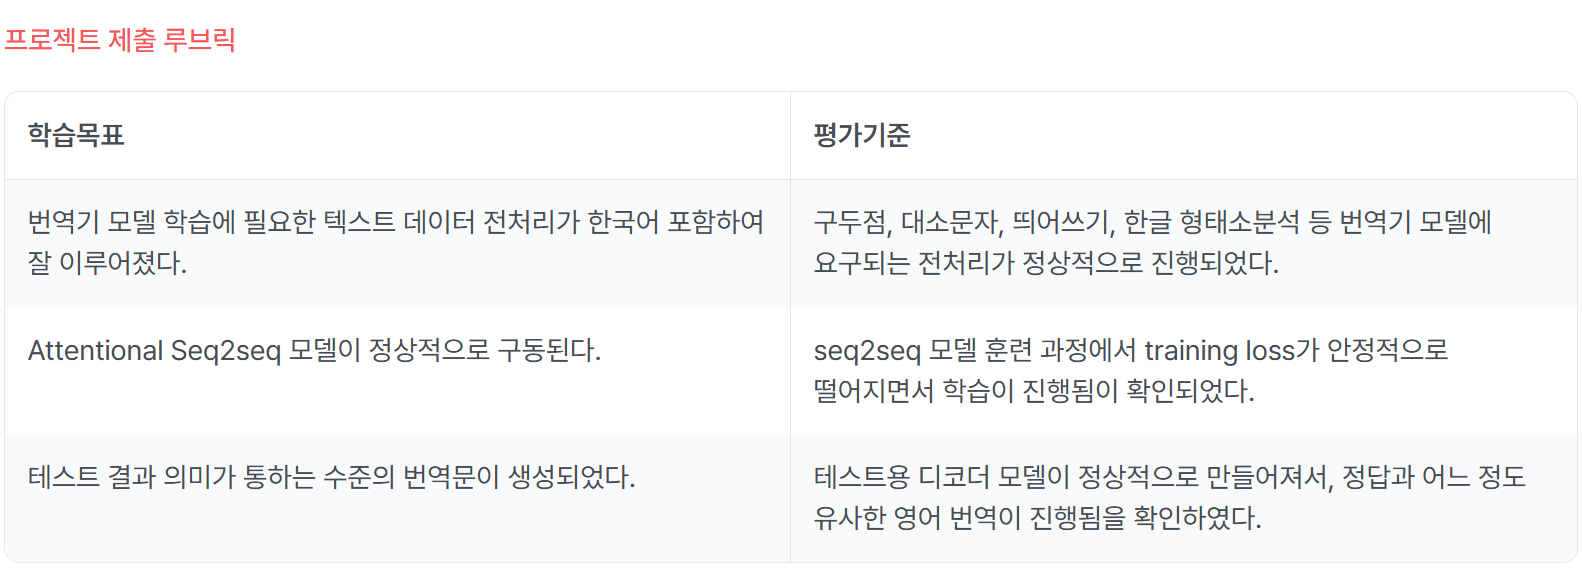

# STEP 0. 라이브러리 & 데이터 로드

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 폰트 설정

In [2]:
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.5 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import logging

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

fontpath = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
fontprop = fm.FontProperties(fname=fontpath, size=12)
plt.rcParams["font.family"] = fontprop.get_name()

print(f"설정된 폰트: {fontprop.get_name()}")

설정된 폰트: NanumBarunGothic


## 사용할 라이브러리

In [14]:
import os
import re
import urllib.request
import zipfile
import sentencepiece as spm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)

2.8.0+cu126


## 데이터 로드

In [5]:
%cd "/content/drive/MyDrive/Colab Notebooks/아이펠/AIFFEL_quest_rs/GoingDeeper/GD04"

/content/drive/MyDrive/Colab Notebooks/아이펠/AIFFEL_quest_rs/GoingDeeper/GD04


In [6]:
dataset_dir = "./data/kor-eng/kor-eng"
path_to_file = os.path.join(dataset_dir, "kor.txt")

print("데이터셋 디렉토리:", os.listdir(dataset_dir))
print("한글 데이터 파일 경로:", path_to_file)

데이터셋 디렉토리: ['_about.txt', 'kor.txt']
한글 데이터 파일 경로: ./data/kor-eng/kor-eng/kor.txt


# STEP 1. EDA & 전처리

In [7]:
# 샘플 확인
df = pd.read_csv(path_to_file,
                 sep = "\t",
                 names = ["eng", "kor", "attribution"]).drop(columns=["attribution"])
df.head()

,eng,kor
0,Go.,가.
1,Hi.,안녕.
2,Run!,뛰어!
3,Run.,뛰어.
4,Who?,누구?


## EDA

In [8]:
# 중복 확인
print(df.duplicated().sum())

# 결측치 확인
print(df.isna().sum())

0
eng    0
kor    0
dtype: int64



=== 길이 통계 ===
      eng_len_char  kor_len_char
0                3             2
1                3             3
2                4             3
3                4             3
4                4             3
...            ...           ...
6376           127            61
6377           142            63
6378           161            82
6379           262           111
6380           537           296

[6381 rows x 2 columns]


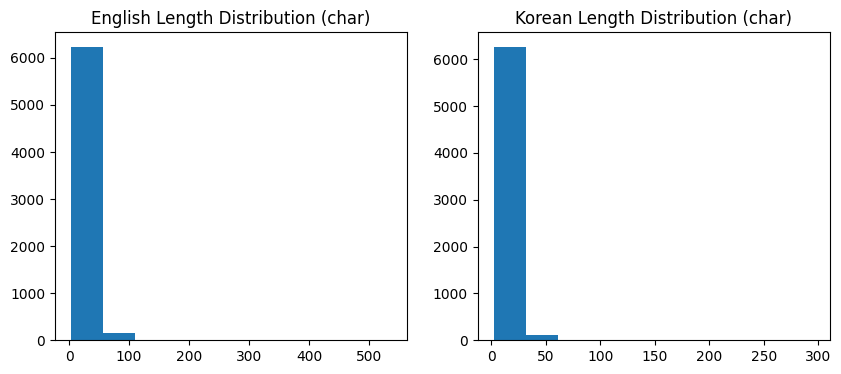

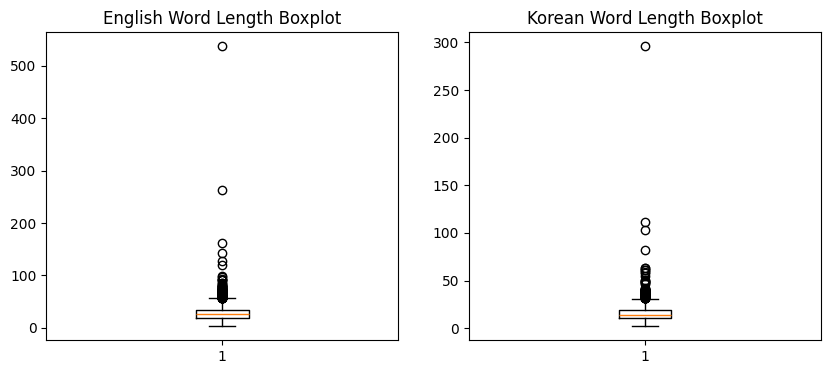



=== 중복 개수 ===
영어 문장 중복: 678
한국어 문장 중복: 314


=== 특수문자/문장부호 종류 ===
영어 문장에서 등장한 특수문자: ['!', '"', '$', '%', "'", ',', '-', '.', ':', ';', '?', '°']
한국어 문장에서 등장한 특수문자: ['!', '"', '%', '(', ')', ',', '-', '.', '/', ':', '?', '~', '°']
전체에서 등장한 특수문자: ['!', '"', '$', '%', "'", '(', ')', ',', '-', '.', '/', ':', ';', '?', '~', '°']


In [9]:
# 복사본 생성
df_copy = df.copy()

# ---------------------------
# 1. 길이 통계
# ---------------------------
df_copy["eng_len_char"] = df_copy["eng"].str.len()
df_copy["kor_len_char"] = df_copy["kor"].str.len()

print("\n=== 길이 통계 ===")
print(df_copy[["eng_len_char", "kor_len_char"]])

# 히스토그램
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df_copy["eng_len_char"])
plt.title("English Length Distribution (char)")

plt.subplot(1,2,2)
plt.hist(df_copy["kor_len_char"])
plt.title("Korean Length Distribution (char)")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.boxplot(df_copy["eng_len_char"])
plt.title("English Word Length Boxplot")

plt.subplot(1,2,2)
plt.boxplot(df_copy["kor_len_char"])
plt.title("Korean Word Length Boxplot")
plt.show()

# ---------------------------
# 2. 중복
# ---------------------------
print("\n\n=== 중복 개수 ===")
print("영어 문장 중복:", df_copy["eng"].duplicated().sum())
print("한국어 문장 중복:", df_copy["kor"].duplicated().sum())


# ---------------------------
# 3. 특수문자/문장부호 분석
# ---------------------------
def extract_special_chars(series):
    # 시리즈 전체 문자열 합치기
    all_text = " ".join(series)

    # 단어(\w)와 공백(\s)을 제외한 모든 문자 = 특수문자/문장부호
    specials = re.findall(r"[^\w\s]", all_text)

    # 중복 제거 + 정렬
    return sorted(set(specials))


eng_specials = extract_special_chars(df["eng"])
kor_specials = extract_special_chars(df["kor"])
all_specials = sorted(set(eng_specials + kor_specials))

print("\n\n=== 특수문자/문장부호 종류 ===")
print("영어 문장에서 등장한 특수문자:", eng_specials)
print("한국어 문장에서 등장한 특수문자:", kor_specials)
print("전체에서 등장한 특수문자:", all_specials)

### **EDA 결과**
---

### **1. 중복 처리**

(1) 문장 부호 빼면 똑같은 행들  

예시:
```
Run!	뛰어!
Run.	뛰어.
```
해결 방법:  
1. 문장 부호 모두 제거 후 중복 행 제거
    - 뉘앙스가 사라져서 번역기 성능이 낮아질 수 있음
2. 그대로 두기
    - 학습 효율이 떨어질 것 같음  
  
<br>

(2) 영어 원문 하나에 한국어 표현 여러 개  

예시:
```
Wait!   기다려!
Wait!   잠깐!
```
해결 방법:  
1. 영어 기준 하나만 남기기  
    - (1)과 마찬가지로 다양한 의미를 포함하지 못해 번역기 성능이 낮아질 수 있음  
2. 그대로 두기  
    - 이것 역시 학습 효율이 떨어질 것 같음
<br>

(1), (2) 모두 일단 그대로 두는 것을 baseline으로 하고 추가 실험을 진행해 보는 방법이 괜찮아 보임.  
<br>

---
### **2. 시퀀스 길이**  

시퀀스 길이 분포를 보니 극단적인 이상치가 존재함. 따라서
1. 토큰화 후 토큰 길이의 분포를 다시 확인  
2. 최대 길이 max_length 지정  
3. max_length에 맞춰서 토큰화된 시퀀스를 cut  
4. padding  

순서로 진행할 것.


## 전처리

### text 전처리

In [10]:
# 전처리 함수 정의
def preprocess_text(text):
    """
    텍스트 전처리 함수
    """
    if pd.isna(text):
        return ""

    text = str(text)

    # 1. 소문자화
    text = text.lower()

    # 2. 반복되는 문장 부호 제거 (2개 이상 → 1개)
    text = re.sub(r'([.!?,])\1+', r'\1', text)

    # 3. 영어/숫자/한글/문장부호만 남기고 모두 삭제
    # 이모지, 이모티콘, 특수문자 자동 제거
    text = re.sub(r"[^가-힣a-zA-Z0-9\s.!?,']", " ", text)

    # 4. 문장부호 앞뒤로 공백 추가
    text = re.sub(r'([.!?,])', r' \1 ', text)

    # 5. 연속 공백을 하나의 공백으로 교체
    text = re.sub(r'\s+', ' ', text)

    # 6. 앞뒤 공백 제거
    text = text.strip()

    return text

In [12]:
df["eng"] = df["eng"].apply(preprocess_text)
df["kor"] = df["kor"].apply(preprocess_text)

df.head()

,eng,kor
0,go .,가 .
1,hi .,안녕 .
2,run !,뛰어 !
3,run .,뛰어 .
4,who ?,누구 ?


In [13]:
# 파일 저장
df["eng"].to_csv("eng_corpus.txt", index=False, header=False, sep="\n", encoding="utf-8")
df["kor"].to_csv("kor_corpus.txt", index=False, header=False, sep="\n", encoding="utf-8")

print("파일 저장 완료: eng_corpus.txt, kor_corpus.txt")

파일 저장 완료: eng_corpus.txt, kor_corpus.txt


### 토큰화

In [15]:
vocab_size = 3000
pad_id = 0
bos_id = 1
eos_id = 2
unk_id = 3

# 1. 영어 모델 학습
spm.SentencePieceTrainer.train(
    input='eng_corpus.txt',
    model_prefix='encoder_spm',
    vocab_size=vocab_size,
    model_type='bpe',
    character_coverage=1.0, # 모든 문자 포함
    pad_id=pad_id,
    bos_id=bos_id,
    eos_id=eos_id,
    unk_id=unk_id
)

# 2. 한국어 모델 학습
spm.SentencePieceTrainer.train(
    input='kor_corpus.txt',
    model_prefix='decoder_spm',
    vocab_size=vocab_size,
    model_type='bpe',
    character_coverage=1.0,
    pad_id=pad_id,
    bos_id=bos_id,
    eos_id=eos_id,
    unk_id=unk_id
)

print("SentencePiece 모델 학습 완료!")

SentencePiece 모델 학습 완료!


In [16]:
# SentencePiece 모델 로드
encoder_tokenizer = spm.SentencePieceProcessor()
encoder_tokenizer.load("encoder_spm.model") # 영어

decoder_tokenizer = spm.SentencePieceProcessor()
decoder_tokenizer.load("decoder_spm.model") # 한국어

True

In [19]:
# 샘플로 인코딩, 디코딩 확인
eng_sample = df["eng"][5000]
spa_sample = df["kor"][5000]
print(eng_sample)
print(spa_sample)

# bos, eos 토큰 추가
enc_token = encoder_tokenizer.encode(eng_sample)
enc_token = [encoder_tokenizer.bos_id()] + enc_token + [encoder_tokenizer.eos_id()]
print("\n인코딩 토큰:", enc_token)

# 위 토큰을 디코딩하면?
enc_decoding = encoder_tokenizer.decode(enc_token)
print("디코딩 토큰:", enc_decoding)

i'm glad that you're back in boston .
네가 보스턴으로 돌아와서 기쁘다 .

인코딩 토큰: [1, 6, 2980, 2971, 1541, 49, 21, 2980, 13, 464, 54, 323, 5, 2]
디코딩 토큰: i'm glad that you're back in boston .


영어 최대 길이: 129
한국어 최대 길이: 146
영어 평균 길이: 7.67
한국어 평균 길이: 7.67
------------------------------
상위 90% 길이 -> 영어: 12 | 한국어: 12
상위 95% 길이 -> 영어: 13 | 한국어: 13
상위 99% 길이 -> 영어: 17 | 한국어: 18
상위 99.9% 길이 -> 영어: 26 | 한국어: 32


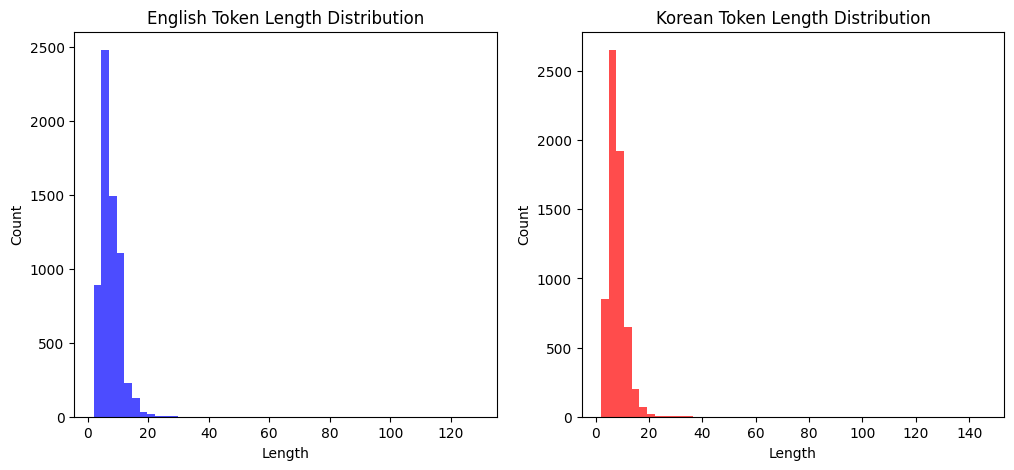

In [20]:
# 토큰화 후 데이터 분포 확인

# df_copy 전처리
df_copy["eng"] = df_copy["eng"].apply(preprocess_text)
df_copy["kor"] = df_copy["kor"].apply(preprocess_text)

# 2. 전체 데이터 토큰화 및 길이 계산
# encode_as_ids: 텍스트를 정수 시퀀스로 변환
df_copy['eng_sp_ids'] = df_copy['eng'].apply(lambda x: encoder_tokenizer.encode_as_ids(str(x)))
df_copy['kor_sp_ids'] = df_copy['kor'].apply(lambda x: decoder_tokenizer.encode_as_ids(str(x)))

# 길이 계산
df_copy['eng_sp_len'] = df_copy['eng_sp_ids'].apply(len)
df_copy['kor_sp_len'] = df_copy['kor_sp_ids'].apply(len)

# 3. 통계 정보 출력
print(f"영어 최대 길이: {df_copy['eng_sp_len'].max()}")
print(f"한국어 최대 길이: {df_copy['kor_sp_len'].max()}")
print(f"영어 평균 길이: {df_copy['eng_sp_len'].mean():.2f}")
print(f"한국어 평균 길이: {df_copy['kor_sp_len'].mean():.2f}")

# 4. 백분위수(Percentile) 확인 (중요!)
# 90%, 95%, 99%에 해당하는 길이를 확인합니다.
print("-" * 30)
for per in [90, 95, 99, 99.9]:
    eng_len = np.percentile(df_copy['eng_sp_len'], per)
    kor_len = np.percentile(df_copy['kor_sp_len'], per)
    print(f"상위 {per}% 길이 -> 영어: {int(eng_len)} | 한국어: {int(kor_len)}")

# 5. 시각화 (히스토그램)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_copy['eng_sp_len'], bins=50, alpha=0.7, color='blue')
plt.title('English Token Length Distribution')
plt.xlabel('Length')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(df_copy['kor_sp_len'], bins=50, alpha=0.7, color='red')
plt.title('Korean Token Length Distribution')
plt.xlabel('Length')
plt.ylabel('Count')

plt.show()

특수 토큰들을 포함해서 max_lenth=40 정도만 해도 전체 데이터의 99.9%를 커버할 수 있기 때문에,  
최대 길이는 40으로 지정한다.

### 데이터로더

In [28]:
class TranslationDataset(Dataset):
    def __init__(self, data, encoder_tokenizer, decoder_tokenizer, max_len):
        self.data = data
        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer
        self.max_len = max_len
        self.pad_id = encoder_tokenizer.pad_id()
        self.bos_id = encoder_tokenizer.bos_id()
        self.eos_id = encoder_tokenizer.eos_id()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 데이터 로드 (혹시 모를 비문자열 방지를 위해 str 변환)
        src_text = str(self.data.iloc[idx]['eng'])
        trg_text = str(self.data.iloc[idx]['kor'])

        # 1. 토큰화 (IDs로 변환)
        src_ids = self.encoder_tokenizer.encode_as_ids(src_text)
        trg_ids = self.decoder_tokenizer.encode_as_ids(trg_text)

        # 2. 최대 길이 제한 (Special Token 공간 확보를 위해 미리 자름)
        # Encoder: [Text] + [EOS] -> 1개 공간 필요
        # Decoder: [SOS] + [Text] + [EOS] -> 2개 공간 필요 (하지만 입/출력을 쪼개므로 각각 1개씩)

        if len(src_ids) > self.max_len - 1:
            src_ids = src_ids[:self.max_len - 1]

        if len(trg_ids) > self.max_len - 2: # SOS, EOS 고려해서 -2
            trg_ids = trg_ids[:self.max_len - 2]

        # 3. Special Token 추가
        # Encoder 입력에도 EOS 추가
        enc_input = src_ids + [self.eos_id]

        # Decoder Input(SOS시작) vs Label(EOS끝) 분리
        dec_input = [self.bos_id] + trg_ids
        dec_label = trg_ids + [self.eos_id]

        # 4. Padding
        # Encoder Padding
        enc_padding_len = self.max_len - len(enc_input)
        if enc_padding_len > 0:
            enc_input = enc_input + [self.pad_id] * enc_padding_len

        # Decoder Padding (Input과 Label 길이를 동일하게 맞춰야 함)
        dec_padding_len = self.max_len - len(dec_input)
        if dec_padding_len > 0:
            dec_input = dec_input + [self.pad_id] * dec_padding_len
            dec_label = dec_label + [self.pad_id] * dec_padding_len

        # 5. 텐서 변환 (LongTensor가 정수형 인덱스에 적합, 가독성)
        return {
            'src': torch.tensor(enc_input, dtype=torch.long),
            'trg_input': torch.tensor(dec_input, dtype=torch.long),
            'trg_label': torch.tensor(dec_label, dtype=torch.long)
        }

In [29]:
train_ratio = 0.8
MAX_LEN = 40
BATCH_SIZE = 64

train_data = df.sample(frac=train_ratio, random_state=42)
valid_data = df.drop(train_data.index)

train_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)

train_data = TranslationDataset(train_data, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)
validataion_data = TranslationDataset(valid_data, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validataion_data, batch_size=BATCH_SIZE, shuffle=False)

In [30]:
# Shape 확인
for batch in train_loader:
    src = batch['src']
    trg_input = batch['trg_input']
    trg_label = batch['trg_label']

    print(f"Src Shape: {src.shape}")
    print(f"Trg Input Shape: {trg_input.shape}")
    print(f"Trg Label Shape: {trg_label.shape}")
    break

Src Shape: torch.Size([64, 40])
Trg Input Shape: torch.Size([64, 40])
Trg Label Shape: torch.Size([64, 40])


# STEP 2. 모델 설계
각각 1개의 GRU를 갖는 Encoder-Decoder 구조를 설계할 것이다

In [31]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: (batch_size, hidden_dim)
        # encoder_outputs: (src_len, batch_size, hidden_dim)

        src_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)  # (batch_size, src_len, hidden_dim)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # (batch_size, src_len, hidden_dim)

        energy = torch.tanh(self.W1(encoder_outputs) + self.W2(hidden))  # (batch_size, src_len, hidden_dim)
        attention = self.v(energy).squeeze(2)  # (batch_size, src_len)

        return nn.functional.softmax(attention, dim=1)  # (batch_size, src_len)

In [32]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim)

    def forward(self, src):
        # src : (src_len, batch_size)
        embedded = self.embedding(src)  # embedded : (src_len, batch_size, emb_dim)
        outputs, hidden = self.rnn(embedded)  # outputs : (src_len, batch_size, hidden_dim)

        return outputs, hidden

In [39]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, attention):
        super(Decoder, self).__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        # Decoder RNN에는 embedding만 입력
        self.rnn = nn.GRU(emb_dim, hidden_dim)
        # 출력층에는 hidden state와 attention value가 결합되어 입력
        self.fc_out = nn.Linear(hidden_dim + hidden_dim, output_dim)

    def forward(self, input, hidden, encoder_outputs):
        # input : (batch_size,)
        # hidden : (batch_size, hidden_dim)
        # encoder_outputs : (src_len, batch_size, hidden_dim)
        input = input.unsqueeze(0)  # input : (1, batch_size)
        embedded = self.embedding(input)  # embedded : (1, batch_size, emb_dim)

        # attention distribution을 계산합니다. decoder의 이전 hidden state, s_{t-1}와 encoder의 H가 입력됩니다.
        a = self.attention(hidden[-1], encoder_outputs)  # a : (batch_size, src_len)

        # H에 가중치를 부여해 attention value(Context vector) 계산
        a = a.unsqueeze(1)  # a : (batch_size, 1, src_len)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # encoder_outputs : (batch_size, src_len, hidden_dim)
        context = torch.bmm(a, encoder_outputs)  # context : (batch_size, 1, hidden_dim)
        context = context.permute(1, 0, 2)  # context : (1, batch_size, hidden_dim)

        output, hidden = self.rnn(embedded, hidden)

        # 출력층에서는 현재 hidden state와 context vector를 결합하여 예측값 생성
        output = output.squeeze(0)  # output : (batch_size, hidden_dim)
        context = context.squeeze(0)  # context : (batch_size, hidden_dim)
        prediction = self.fc_out(torch.cat((output, context), dim=1))  # (batch_size, output_dim)

        return prediction, hidden, a.squeeze(1)

In [40]:
class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg=None, max_len=30, bos_id = 1, eos_id=2):
        # 학습 모드에서는 trg_len 사용, 추론 모드에서는 max_len까지 동적 생성
        batch_size = src.shape[1]
        trg_vocab_size = self.decoder.fc_out.out_features

        # 조기 종료를 위해 tensor가 아닌 리스트 사용
        outputs = []

        # 시각화를 위해 attention 저장
        attentions = []

        # 인코더를 통해 context 생성
        encoder_outputs, hidden = self.encoder(src)

        if trg is not None:
            for t in range(0, trg.shape[0]):
                input = trg[t]
                output, hidden, attention = self.decoder(input, hidden, encoder_outputs)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))

        else:
		    # inference에서는 target(정답)이 없기 때문에 sos_token을 생성해줍니다.
            input = torch.full((batch_size,), bos_id, dtype=torch.long, device=self.device)
            finished = torch.zeros(batch_size, dtype=torch.bool, device=self.device)

            for t in range(max_len):
                output, hidden, attention = self.decoder(input, hidden,  encoder_outputs)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))
                top1 = output.argmax(1)
                input = top1

                # 조기 종료 조건
                finished |= (top1 == eos_id)
                if finished.all():
                    break

        outputs = torch.cat(outputs, dim=0)  # (trg_len, batch_size, output_dim)
        attentions = torch.cat(attentions, dim=0)  # (trg_len, batch_size, src_len)

        return outputs, attentions

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = len(encoder_tokenizer)
output_dim = len(decoder_tokenizer)
emb_dim = 256
hid_dim = 512

encoder = Encoder(input_dim, emb_dim, hid_dim).to(device)
attention = BahdanauAttention(hid_dim).to(device)
decoder = Decoder(output_dim, emb_dim, hid_dim, attention).to(device)
model = Seq2SeqAttention(encoder, decoder, device).to(device)

print(model)

Seq2SeqAttention(
  (encoder): Encoder(
    (embedding): Embedding(3000, 256)
    (rnn): GRU(256, 512)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (W1): Linear(in_features=512, out_features=512, bias=True)
      (W2): Linear(in_features=512, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(3000, 256)
    (rnn): GRU(256, 512)
    (fc_out): Linear(in_features=1024, out_features=3000, bias=True)
  )
)


# STEP 3. 모델 학습

## (1) Optimizer & Loss

In [41]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)

## (2) train_step
학습에 필요한 것을 모두 가져가 Loss를 계산한 후 반환하는 함수  

1. model.train()을 호출하여 모델을 학습 모드로 전환합니다.
2. optimizer.zero_grad()를 통해 이전 배치에서 계산된 기울기를 초기화합니다.
3. Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out 을 생성
4. t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의. h_dec = enc_hidden Encoder 처리
5. <start> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. predictions
6. 예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예측 단어 사용X)
7. 반복!

In [42]:
def train_step(model, data_loader, optimizer, criterion, epoch):
    model.train()
    epoch_loss = 0

    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}", leave=True)

    for batch in train_loader:
        src = batch['src'].to(device)
        trg_input = batch['trg_input'].to(device)
        trg_label = batch['trg_label'].to(device)

        optimizer.zero_grad()

        # 모델 입력
        outputs = model(src, trg_input)

        # (trg_len, batch_size, output_dim)을 (batch_size * trg_len, output_dim)으로 변환
        outputs = outputs.view(-1, outputs.shape[-1])
        trg_label = trg_label.view(-1)

        loss = criterion(outputs, trg_label)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        epoch_loss += loss.item()

        progress_bar.set_postfix(loss=loss.item())

    return epoch_loss / len(data_loader)

## (3) 학습 시작

In [ ]:
%%time

EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss = train_step(model, train_loader, optimizer, criterion, epoch)
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}')

In [43]:
def eval_step(model, data_loader, optimizer, criterion):
    model.eval()
    total_loss = 0

    for batch in train_loader:
        src = batch['src'].to(device)
        trg_input = batch['trg_input'].to(device)
        trg_label = batch['trg_label'].to(device)

        optimizer.zero_grad()

        # 모델 입력
        outputs = model(src, trg_input)

        # (trg_len, batch_size, output_dim)을 (batch_size * trg_len, output_dim)으로 변환
        outputs = outputs.view(-1, outputs.shape[-1])
        trg_label = trg_label.view(-1)

        loss = criterion(outputs, trg_label)

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [ ]:
%%time

EPOCHS = 20

for epoch in range(EPOCHS):
    train_loss = train_step(model, train_loader, optimizer, criterion, epoch)
    valid_loss = eval_step(model, validation_loader, optimizer, criterion)
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

In [44]:
def evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=30):
    model.eval()

    sentence = preprocess_sentence(sentence)
    src_ids = encoder_tokenizer.encode(sentence)
    src_ids = src_ids[:max_len]
    src_ids = src_ids + [0] * (max_len - len(src_ids))  # 패딩 추가
    src_tensor = torch.tensor(src_ids).unsqueeze(1).to(device)  # (src_len, 1)

    with torch.no_grad():
        outputs, attentions = model(src_tensor, max_len=max_len)

    result = [decoder_tokenizer.decode([token.item()]) for token in outputs.argmax(2).squeeze(1)]

    if "<end>" in result:
        result = result[:result.index("<end>")]

    return result, sentence, attentions.squeeze(1).cpu().numpy()

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticks(range(len(sentence)))
    ax.set_xticklabels(sentence, fontdict=fontdict, rotation=90)

    ax.set_yticks(range(len(predicted_sentence)))
    ax.set_yticklabels(predicted_sentence, fontdict=fontdict)

    plt.show()

In [ ]:
def translate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=30):
    result, sentence, attention = evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    # Attention 크기 조정 (trg_len, src_len)
    attention = attention[:len(result), :len(sentence.split())]

    plot_attention(attention, sentence.split(), result)

In [ ]:
translate("The most powerful man all over the world.", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

In [ ]:
translate("May I help you?", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

In [ ]:
translate("Can I have some coffee?", model, encoder_tokenizer, decoder_tokenizer, max_len=30)